In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [9]:
# Reading the dataframe and creating a list with column names
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [10]:
# setting the column names as the names on our list
df.columns = dataset_cols

# Transforming the functional column from "Yes" or "No" to 1 or 0 for better NN training  
df["functional"] = (df["functional"] =="Yes").astype(int)

df = df[df["hour"]==12]
df = df.drop(["hour"], axis=1)

We are just going to analyse a really small subset of the whole data contained is the big DataFrame read from teh .csv file. I'm gonna use just the feature vectors with hour as 12, anyone who is actually searching for a production level NN should use all the data. The reason I choose to use just this small subset of the data is because the objective of the project is learning, so this will speed up the computation part.

In [11]:
# Taking a look at our filtered DataFrame
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


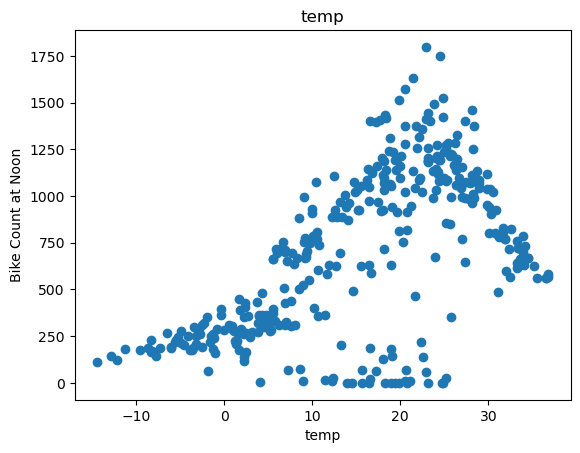

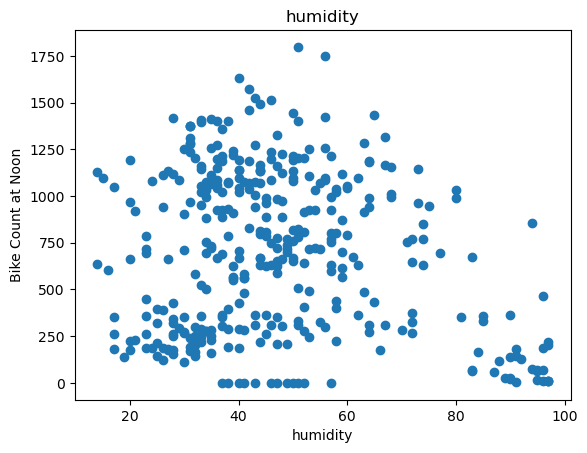

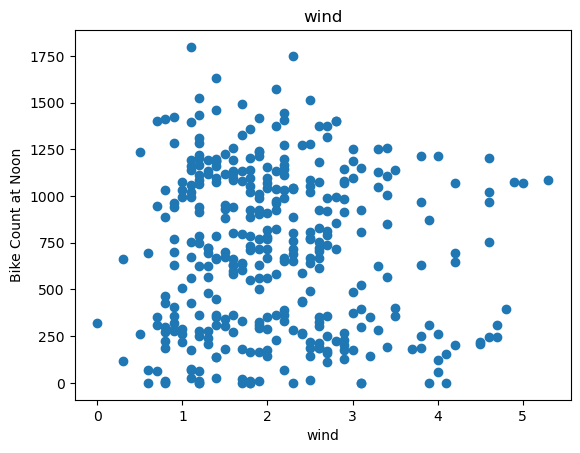

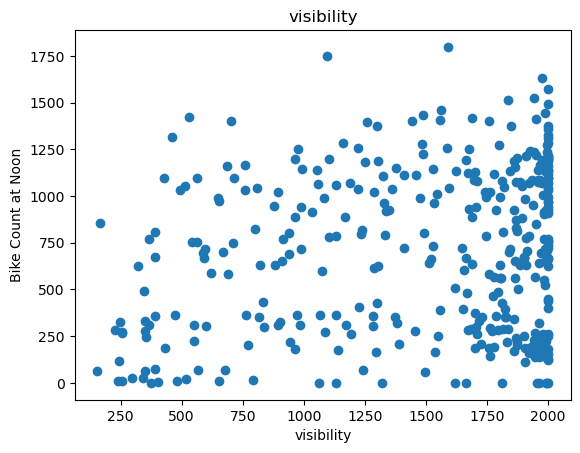

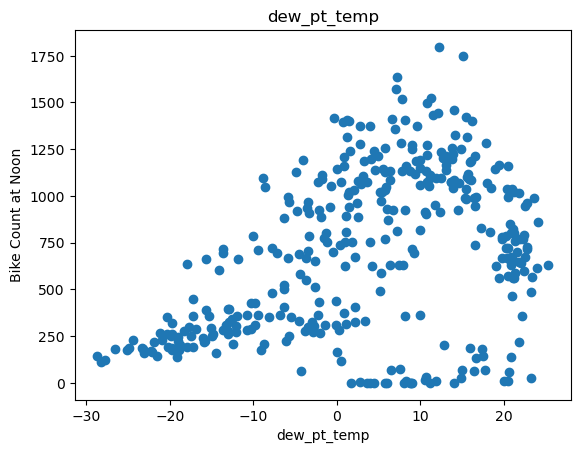

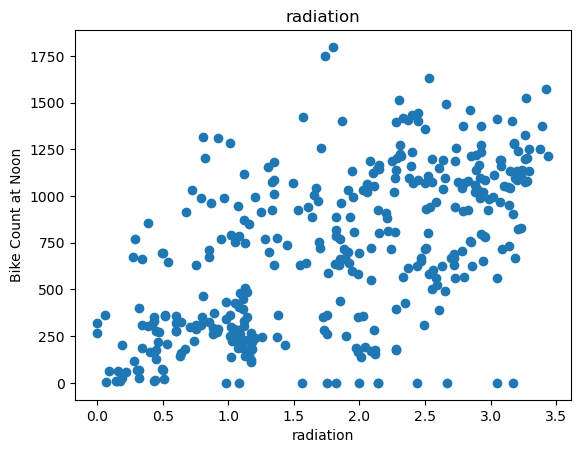

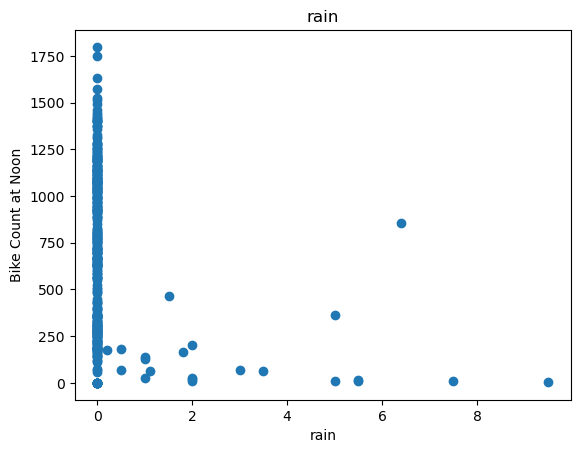

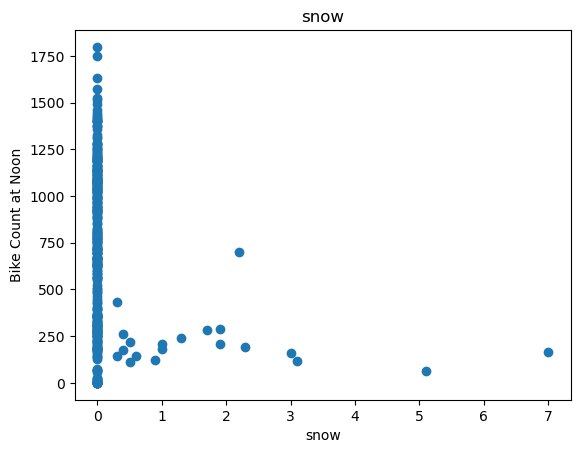

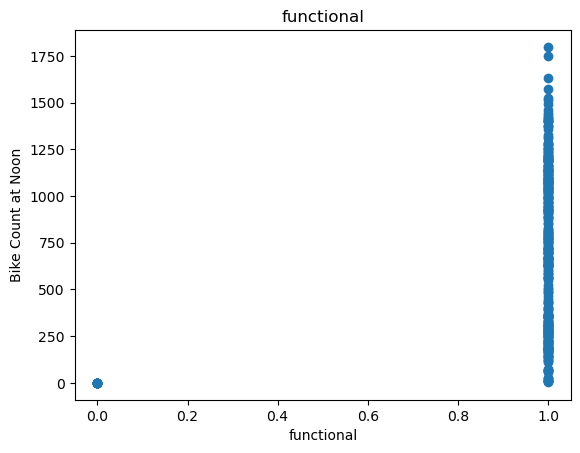

In [12]:
# Ploting all the differente metrics to see which ones are relevant
# Always bike count in the Y axis and the other metric in the X axis
for label in df.columns[1:]:
    # The actual plot
    plt.scatter(df[label], df["bike_count"])
    
    # Organization stuff
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    
    # Showing
    plt.show()

In [13]:
# Dropping the columns that are not gonna help predicting the bike count
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [14]:
# Looking at the ultra filtered DataFrame
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/ Valid/ Test Datasets

We are going to split our DataFrame into 3 different Datasets. One is gonna be for training, the other one for validation for the training, and the last one for the final test of the Neural Net.

In [15]:
# splitting using np.split, an extremely powerfull function
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [18]:
def get_xy(dataframe, y_label, x_labels=None):
    #using the copy library
    dataframe = copy.deepcopy(dataframe)
    
    # x_labels is the parameter that would indicate specific columns for get_xy, if none that means all of them
    if x_labels is None:
        x = dataframe[[c for c in dataframe.columns if c!=y_labels]].values
    else:
        if len(x_labels) == 1: # need this specific case because Numpy is picky about sizes
            x = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            x = dataframe[x_labels].values 

    y = dataframe[y_label].values.reshape(-1,1) # reshaping for hstack to work
    data = np.hstack((x,y)) #getting the dataframes together horizontally
    
    return data, x, y
    
            

In [26]:
# We are just gonna use the "temperature column since this is the one with the highest correlation to bike count
# Calling our get_xy function in our 3 DataFrames
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels =["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels =["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels =["temp"])

#note the underscore in the beggining, that is because I don't care about the first return of our function

In [23]:
# Creating our lN model
temp_reg = LinearRegression()

# Using it on our training data
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [24]:
temp_reg.score(x_test_temp, y_test_temp)

0.37320553484672325

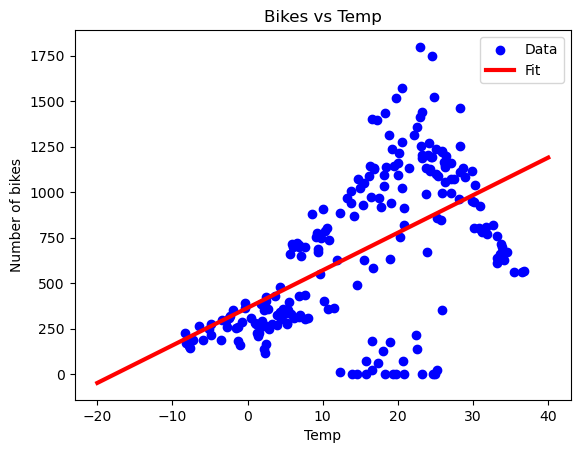

In [25]:
# Ploting our regression line on the Bike vs Temp graph

plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label = "Fit", color="red", linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

The data doesn't fit very well the regression line...

# Multiple Linear Regression

Instead of just using the temperature column, lets use all the other ones as well.

In [28]:
# Again splitting the train data (with all columns this time) into 3 using np,split
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns[1:]) # using [1:] to not get the first column
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels = df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels = df.columns[1:])

In [29]:
# Creating the LN model for the multicolumn DataFrame
all_reg = LinearRegression()

# Using it on our training Data
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [30]:
all_reg.score(x_test_all, y_test_all)

0.3820653587220012

Pretty bad score, indicating our data really doesn't fit well into a regression model.

In [33]:
y_pred_lr = all_reg.predict(x_test_all)

# Regression with Neural Net

Now for the fun part, lets see if we can build and train a neural network that outperforms the multiple regression.

In [34]:
# Function to plot the results of the NN training. Straight from Tensorflow
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
# Defining the normalizer, didn't undertand this at all :)
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [44]:
temp_nn_model = tf.keras.Sequential([
    # Using the normalizer we created earlier
    temp_normalizer,
    
    # Defining a linear model
    tf.keras.layers.Dense(1)
])

In [48]:
# Compiling our NN model, some important things to note are:
#  The learning_rate being small is important for our model not to diverge, but since this a linear model we can have a pretty high learning rate
#  We are calculating the loss using mean squared error, this is a choice I made, try experimenting with other loss models
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.1), loss = "mean_squared_error")

In [51]:
# This is the NN training cell, it may take a while to run
history = temp_nn_model.fit(
x_train_temp.reshape(-1), y_train_temp,
verbose=0, epochs=10000, validation_data=(x_val_temp, y_val_temp))


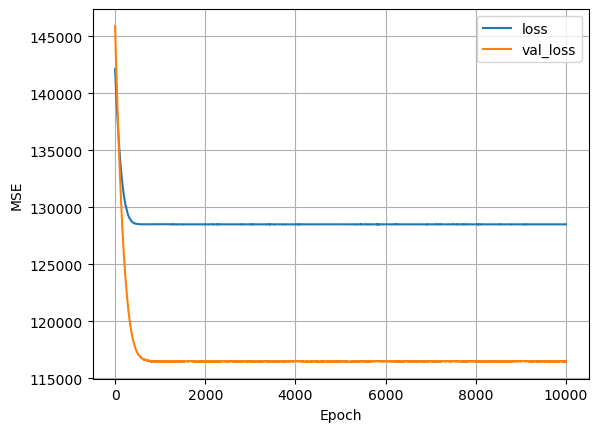

In [53]:
plot_loss(history)

This graph shows the evolution of our training model trough time. It clearly converged. The X axis is the epoch and the Y axis is the mean squared error, so the lower in the Y axis the better.

4/4 [==============================] - 0s 5ms/step


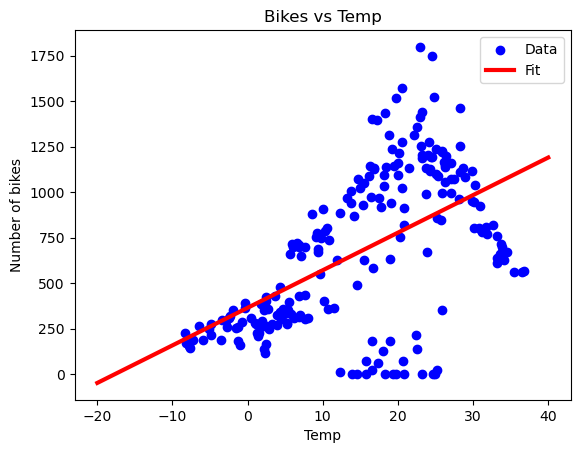

In [54]:
# Plotting the data
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")

# Plotting the regression line created by our model
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)

# Organization stuff
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")

# Showing the plot
plt.show()

#  Neural Net

In [57]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss= "mean_squared_error")
# This is a much more complex NN than the one used previously. The learning rate was decreased to avoid diverging
# If interested try experimenting with this cell in particular, it can be very fun!

In [58]:
# This is the training cell, might take a while to run
history = nn_model.fit(x_train_temp, y_train_temp, validation_data = (x_val_temp, y_val_temp),
                      verbose=0, epochs=100)

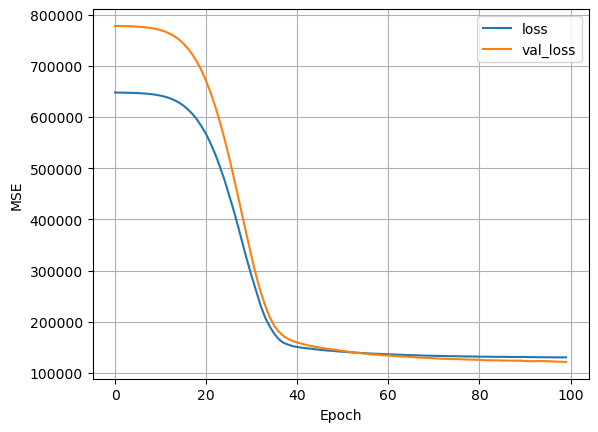

In [59]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


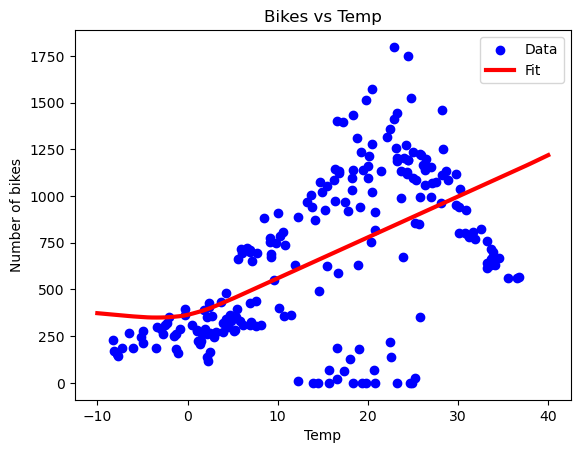

In [62]:
# Plotting the data
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")

# Plotting the regression line created by our model
x = tf.linspace(-10, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)

# Organization stuff
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")

# Showing the plot
plt.show()

Weird regression line. It fits the data better than a straight line though. Still this graph can't really be well described by a line, the data is really spread out.

In [64]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

In [65]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")


In [66]:
history = nn_model.fit(x_train_all, y_train_all, validation_data=(x_val_all, y_val_all),
                      verbose=0, epochs=100)

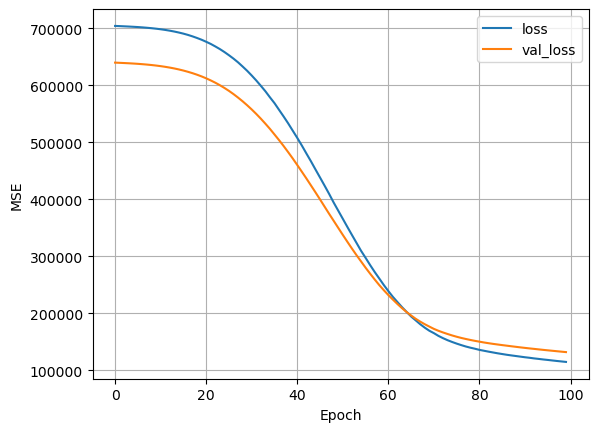

In [67]:
plot_loss(history)

In [68]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 4ms/step


In [69]:
# Simple but powerfull function to calculate the mean squared error
def MSE(y_pred, y_real):
    return (np.square(y_pred-y_real)).mean()

In [70]:
MSE(y_pred_lr, y_test_all)

144905.91572973764

In [71]:
MSE(y_pred_nn, y_test_all)

160708.65747765478

The regression line outperformed the Neural Network. This shows how the simpler method might just be the best

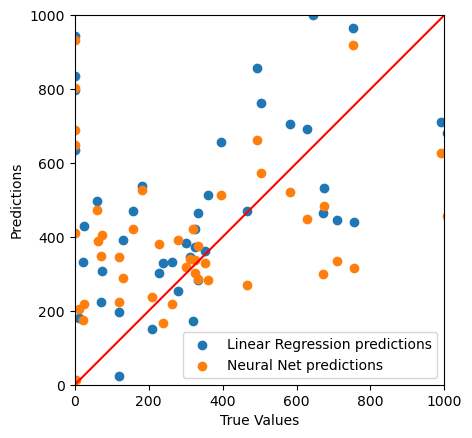

In [72]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Linear Regression predictions")
plt.scatter(y_test_all, y_pred_nn, label="Neural Net predictions")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0,1000]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims,lims,c="red")

This graph shows the predictions that both regression for the given value. Even though the Linear regression outperforms the NN both are pretty bad...